In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import collections as coll
import scipy.stats as sst
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.visualization.fancy_plots import savefig
from src.metrics.consolidated_dprimes_v2 import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, get_centered_means
from src.visualization.fancy_plots import _raster
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2021-03-14 194909.log
[numexpr.utils INFO] NumExpr defaulting to 4 threads.


In [2]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [3]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_mean', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     'fdPCA': 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'sile'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'self_sile')] = 'sile_self'
comp_name_arr[np.where(comp_name_arr == 'diff_sile')] = 'sile_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_sile')] = 'sile_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

# single cell good cells pooling

In [4]:
alpha=0.05
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt = {'contexts': [0, 1, 2, 3, 4],
        'probes': [1, 2, 3, 4]}

In [5]:
# gets significant cells from metric df
good_SC = pivoted.loc[(pivoted["integral (d'*ms)"] > 0) &
                      (pivoted.analysis == 'single cell') ,:]
good_cells = good_SC.id.unique()
good_sites = coll.defaultdict(list)
for cell in good_cells:
    site = cell[:7]
    good_sites[site].append(cell)


sc_pool_dprime = np.full((good_SC.shape[0], 30), np.nan)
sc_pool_signif = np.full((good_SC.shape[0], 30), np.nan)

sc_labels = list()
n=0
for site, cells in good_sites.items():

    dprime, shuffled_dprime, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)
    dprime, shuffled_dprime = flip_dprimes(dprime, shuffled_dprime, flip='sum')
    significance, confidence_interval = _significance(dprime, shuffled_dprime, [3], 3, alpha=alpha)

    for cell in cells:
        for row in good_SC.loc[good_SC.id == cell, ['region','id', 'probe', 'context_pair', 'trans_pair']].iterrows():
            row = row[1]
            cell_idx = goodcells.index(cell)
            ctx_idx = [f'{c0}_{c1}' for c0, c1 in itt.combinations(expt['contexts'], 2)].index(row.context_pair)
            prb_idx = expt['probes'].index(int(row.probe))

            sc_labels.append(row)

            sc_pool_dprime[n,:] = dprime[cell_idx, ctx_idx, prb_idx,:]
            sc_pool_signif[n,:] = significance[cell_idx, ctx_idx, prb_idx,:]
            n += 1


sc_pool_signif_dprime = np.where(sc_pool_signif, sc_pool_dprime, 0)

# labels to index into subset of dataframese
sc_labels = pd.DataFrame(sc_labels)
sc_labels = sc_labels.reset_index(drop=True)
sc_labels = sc_labels.reset_index()

In [52]:
# find good sitese from metric dataframe
good_pop_df = pivoted.loc[(pivoted["integral (d'*ms)"] > 0) &
                      (pivoted.analysis == 'population') ,:]
good_pop_sites = good_pop_df.id.unique()


pop_pool_dprime = np.full((good_pop_df.shape[0], 30), np.nan)
pop_pool_signif = np.full((good_pop_df.shape[0], 30), np.nan)

pop_labels = list()
n=0
for site in good_pop_sites:

    dprime, shuffled_dprime, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)
    dprime, shuffled_dprime = flip_dprimes(dprime, shuffled_dprime, flip='sum')
    significance, confidence_interval = _significance(dprime, shuffled_dprime, [3], 3, alpha=alpha)


    for row in good_pop_df.loc[good_pop_df.id == site, ['region','id', 'probe', 'context_pair', 'trans_pair']].iterrows():
        row = row[1]
        ctx_idx = [f'{c0}_{c1}' for c0, c1 in itt.combinations(expt['contexts'], 2)].index(row.context_pair)
        prb_idx = expt['probes'].index(int(row.probe))

        pop_labels.append(row)

        pop_pool_dprime[n,:] = dprime[0, ctx_idx, prb_idx,:]
        pop_pool_signif[n,:] = significance[0, ctx_idx, prb_idx,:]
        n += 1


pop_pool_signif_dprime = np.where(pop_pool_signif, pop_pool_dprime, 0)

# labels to index into subset of dataframese
pop_labels = pd.DataFrame(pop_labels)
pop_labels = pop_labels.reset_index(drop=True)
pop_labels = pop_labels.reset_index()

In [23]:
analysis = 'single cell'
pooled_dprime = sc_pool_signif_dprime
pooled_significance = sc_pool_signif
labels = sc_labels

In [54]:
analysis = 'population'
pooled_dprime = pop_pool_signif_dprime
pooled_significance = pop_pool_signif
labels = pop_labels

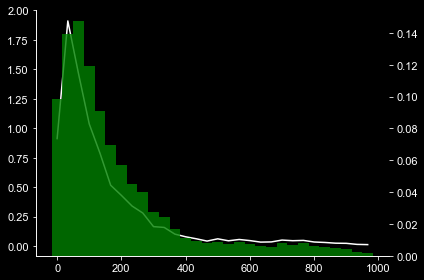

In [55]:
fig, ax = plt.subplots(1)

def plot_pooled(dprime, significancem, ax):
    t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                            endpoint=False) * 1000

    mean_dprime = np.mean(dprime, axis=0)
    ax.plot(t, mean_dprime, color='white')

    twx = plt.twinx(ax)
    norm_singif = np.sum(significancem,  axis=0)/ np.sum(significancem)
    twx.bar(t, norm_singif, width=1000/30, color='green', alpha=0.8)

    fig=ax.get_figure()
    return fig, ax

fig, ax = plot_pooled(pooled_dprime, pooled_significance, ax)
fig.set_size_inches(6,4)

### by regions

population_prop_signif_by_area


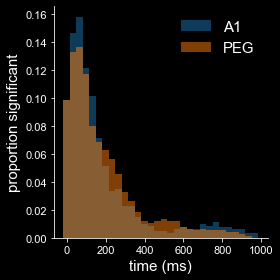

In [56]:
t =  np.linspace(0, pooled_significance.shape[-1] / meta['raster_fs'], pooled_significance.shape[-1],
                                        endpoint=False) * 1000

fig, ax =plt.subplots()
fig.set_size_inches(4,4)
for cc, reg in enumerate(['A1', 'PEG']):
    idx = labels.loc[labels.region == reg, 'index'].values
    norm_singif = np.sum(pooled_significance[idx,:],  axis=0)/ np.sum(pooled_significance[idx,:])
    ax.bar(t, norm_singif, width=1000/30, alpha=0.5, color=f'C{cc}', label=reg)

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('proportion significant')

title = f'{analysis}_prop_signif_by_area'
print(title)
savefig(fig,'EARS_figures', title)

population_mean_dprime_by_area


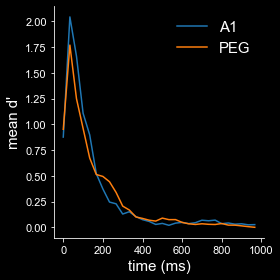

In [57]:
fig, ax =plt.subplots()
fig.set_size_inches(4,4)

for cc, reg in enumerate(['A1', 'PEG']):
    idx = labels.loc[labels.region == reg, 'index'].values
    mean_dprime = np.mean(pooled_dprime[idx,:],  axis=0)
    ax.plot(t, mean_dprime,color=f'C{cc}', label=reg)

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel("mean d'")

title = f'{analysis}_mean_dprime_by_area'
print(title)
savefig(fig,'EARS_figures', title)

### by transition pair

population_prop_signif_by_trans


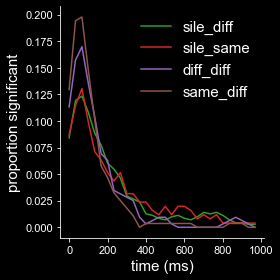

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)

for cc, tp in enumerate(labels.trans_pair.unique()):
    idx = labels.loc[labels.trans_pair == tp, 'index'].values
    norm_singif = np.sum(pooled_significance[idx,:],  axis=0)/ np.sum(pooled_significance[idx,:])
    # ax.bar(t, norm_singif, width=1000/30, alpha=0.5, color=f'C{cc+2}', label=tp)
    ax.plot(t, norm_singif, color=f'C{cc+2}', label=tp)

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel('proportion significant')

title = f'{analysis}_prop_signif_by_trans'
print(title)
savefig(fig,'EARS_figures', title)



population_mean_dprime_by_trans


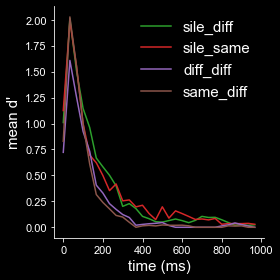

In [59]:
fig, ax = plt.subplots()

for cc, tp in enumerate(labels.trans_pair.unique()):
    idx = labels.loc[labels.trans_pair == tp, 'index'].values
    mean_dprime = np.mean(pooled_dprime[idx,:],  axis=0)
    ax.plot(t, mean_dprime,color=f'C{cc+2}', label=tp)

ax.legend()
ax.set_xlabel('time (ms)')
ax.set_ylabel("mean d'")

title = f'{analysis}_mean_dprime_by_trans'
print(title)
savefig(fig,'EARS_figures', title)
























































